In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-detection-dataset-classification/spam.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Dense,GlobalMaxPooling1D,LSTM,Embedding
from tensorflow.keras.models import Model

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
df = pd.read_csv('/kaggle/input/email-spam-detection-dataset-classification/spam.csv', encoding = "ISO-8859-1")
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
df.columns = ['labels', 'data']
df

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})
Y = df['b_labels'].values

In [7]:
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size = 0.33)

In [8]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [9]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(f'Found {V} unique tokens.')

Found 7223 unique tokens.


In [10]:
data_train = pad_sequences(sequences_train)
print(f"Shape of data train tensor: {data_train.shape}")

Shape of data train tensor: (3733, 189)


In [11]:
T = data_train.shape[1]
T

189

In [12]:
data_test = pad_sequences(sequences_test, maxlen = T)
print(f"Shape of data test tensor: {data_test.shape}")

Shape of data test tensor: (1839, 189)


In [13]:
D = 20
M = 15

i = Input(shape = (T,))
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(i,x)

In [14]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [15]:
r = model.fit(data_train, Ytrain, validation_data = (data_test, Ytest), epochs = 15)

Epoch 1/15
117/117 [==============================] - 25s 164ms/step - loss: 0.4675 - accuracy: 0.8653 - val_loss: 0.3799 - val_accuracy: 0.8673
Epoch 2/15
117/117 [==============================] - 8s 67ms/step - loss: 0.3371 - accuracy: 0.8653 - val_loss: 0.3125 - val_accuracy: 0.8673
Epoch 3/15
117/117 [==============================] - 7s 57ms/step - loss: 0.2939 - accuracy: 0.8653 - val_loss: 0.2806 - val_accuracy: 0.8673
Epoch 4/15
117/117 [==============================] - 3s 25ms/step - loss: 0.2337 - accuracy: 0.8658 - val_loss: 0.1929 - val_accuracy: 0.9125
Epoch 5/15
117/117 [==============================] - 4s 30ms/step - loss: 0.1326 - accuracy: 0.9780 - val_loss: 0.1230 - val_accuracy: 0.9766
Epoch 6/15
117/117 [==============================] - 3s 25ms/step - loss: 0.0742 - accuracy: 0.9922 - val_loss: 0.0942 - val_accuracy: 0.9782
Epoch 7/15
117/117 [==============================] - 2s 21ms/step - loss: 0.0473 - accuracy: 0.9957 - val_loss: 0.0824 - val_accuracy: 0.98

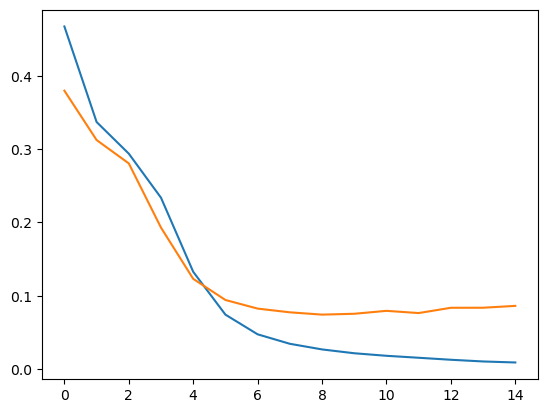

In [16]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.show()

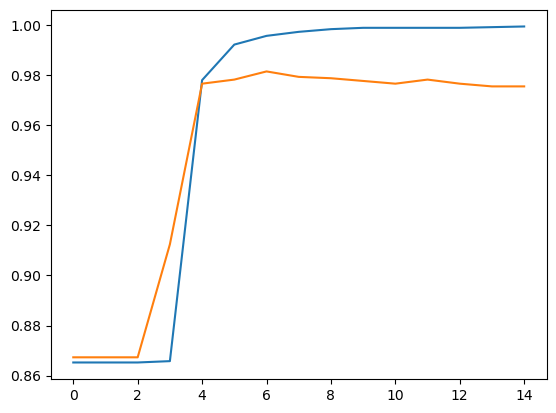

In [17]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.show()

In [18]:
P = model.predict(data_test)
P = P.flatten()

58/58 [==============================] - 1s 4ms/step


In [19]:
model.evaluate(data_test, Ytest)

58/58 [==============================] - 0s 5ms/step - loss: 0.0861 - accuracy: 0.9755


[0.0861218273639679, 0.975530207157135]

58/58 [==============================] - 0s 6ms/step
Confustion matrix, without normalization
[[1595    0]
 [ 244    0]]


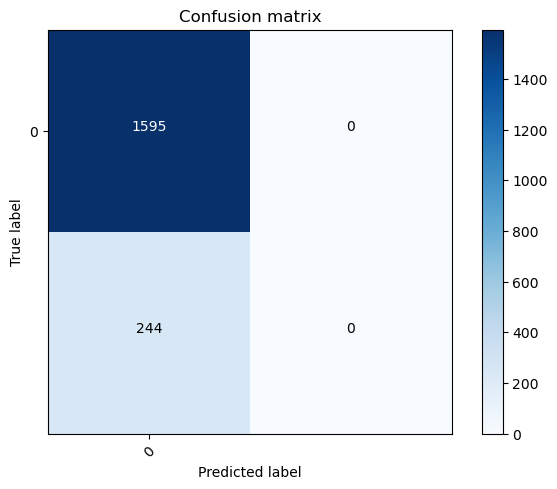

In [20]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
  if normalize:
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confustion matrix, without normalization')
  print(cm)

  plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment = 'center',
             color = 'white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

p_test = model.predict(data_test).argmax(axis = 1)
cm = confusion_matrix(Ytest, p_test)
plot_confusion_matrix(cm, list(range(1)))